In [56]:
import os
import sys
import datetime as dt
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import mlflow
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import itertools
from tqdm import tqdm
import inspect
import matplotlib.pyplot as plt
import seaborn as sns
for m in [pd, tf, tfa, mlflow]:
    print(f"{m.__name__:20s}\t{m.__version__}")

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)
# print('Compute dtype: %s' % policy.compute_dtype)
# print('Variable dtype: %s' % policy.variable_dtype)

tf.config.experimental.enable_tensor_float_32_execution(enabled=True)

OUTPUTPATH = "/mnt/workdata/_WORK_/mail_zonning/mail_zoning/sandbox/"
DATAPATH = "/mnt/workdata/_WORK_/mail_zonning/mail_zoning/dataset/enron_files_annotated/"
FILESTORE = "/mnt/workdata/_WORK_/mail_zonning/mail_zoning/tmp/"
MLFLOW_DIR = "file:///mnt/workdata/_WORK_/mail_zonning/mail_zoning/mlruns/"
TENSORBOARD_DIR = '/mnt/workdata/_WORK_/mail_zonning/mail_zoning/optim/sequenced_bilstm/tblogs/'
ENAME = 'SEQUENCED_CBiGRU_iter_0'

BOM_SIGNAL = 'the start of the email signal, no lines before'
EOM_SIGNAL = 'the end of the email signal, no lines after'




pandas              	1.5.0
tensorflow          	2.9.2
tensorflow_addons   	0.18.0
mlflow              	1.29.0


In [6]:
def prepare_dataset(datapath: str):
    def extract_text(text, flags: dict):
        text = text.split('\n')
        idx = 0
        while text[idx][:2] not in flags:
            idx += 1
        labels = [flags[t[:2]] for t in text[idx:] if len(t) > 1]
        text = [t[2:] for t in text[idx:]]
        return text, labels

    # load and extract flag data
    FLAGS = {'B>': 0, 'H>': 1, 'S>': 2}
    files = {}
    for filename in os.listdir(datapath):
        with open(os.path.join(datapath, filename), 'rt') as f:
            files[filename] = f.read()
    _ = []
    for filename in files.keys():
        text_ = files[filename]
        textlines, labels = extract_text(text_, FLAGS)
        for idx, line_label in enumerate(zip(textlines, labels)):
            _.append({'doc': filename, 'idx': idx, 'sentence': line_label[0], 'label': line_label[1]})
    df = pd.DataFrame.from_dict(_)

    return df


def split_dataset(data: pd.DataFrame, random_state: int):
    """"
    Dataset split is based on complete emails, not on email lines
    """
    splitter = KFold(n_splits=5, shuffle=True, random_state=random_state)
    docs = data['doc'].unique()
    splits = splitter.split(docs)
    train_data = []
    val_data = []
    for train_idx, val_idx in splits:
        train_data_ = data.loc[data['doc'].isin(docs[train_idx])]
        train_data.append(train_data_[['doc', 'idx', 'sentence', 'label']].values)
        val_data_ = data.loc[data['doc'].isin(docs[val_idx])]
        val_data.append(val_data_[['doc', 'idx', 'sentence', 'label']].values)
    return train_data, val_data


def prepare_records(data: np.ndarray, vectorizer):
    DOC = 0
    IDX = 1
    SENT = 2
    LBL = 3
    texts = []
    labels_ = []
    for doc in np.unique(data[:, DOC]):
        sents = np.concatenate([np.array([BOM_SIGNAL]),
                                data[data[:, 0] == doc, SENT],
                                np.array([EOM_SIGNAL])])
        sents = vectorizer(sents).numpy()
        labels = data[data[:, 0] == doc, LBL]
        sents = sliding_window_view(
            x=sents,
            window_shape=(model_params['window_size'],
                          model_params['output_sequence_length']))
        for sent in sents:
            texts.append(sent)
        labels_.extend(labels)
    return np.squeeze(texts), np.stack(labels_)


def report_epoch_progress(epoch, logs):
    mlflow.log_metrics(logs)


def report_master_results(master_results: dict):
    mlflow.log_dict(master_results, 'iteration_results.txt')
    master_results_ = pd.DataFrame(master_results).mean(axis=1).to_dict()
    mean_vals = pd.DataFrame(master_results).mean(axis=1)
    std_vals = pd.DataFrame(master_results).std(axis=1)
    mean_vals.index = [c for c in mean_vals.index]
    std_vals.index = [f"{c}_std" for c in std_vals.index]
    _ = {**mean_vals.to_dict(), **std_vals.to_dict()}
    mlflow.log_metrics(_)
    return master_results_


def define_model_conv_bigru(model_params: dict):
    input_block = tf.keras.layers.Input(
        shape=(model_params['window_size'],
               model_params['output_sequence_length']),
        dtype=tf.int32,
        name='input_block')

    x = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                  output_dim=model_params['embedding_dimension'],
                                  input_length=model_params['output_sequence_length'],
                                  mask_zero=False,
                                  name='embed')(input_block)

    x = tf.keras.layers.BatchNormalization(name='embed_batch_norm')(x)

    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(
            filters=model_params['conv1d_0_units'],
            kernel_size=model_params['conv1d_0_kernelsize'],
            padding=model_params['conv1d_0_padding'],
            activation=model_params['conv1d_0_activation'],
            name='conv1d_0'))(x)

    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(
            filters=model_params['conv1d_1_units'],
            kernel_size=model_params['conv1d_1_kernelsize'],
            padding=model_params['conv1d_1_padding'],
            activation=model_params['conv1d_1_activation'],
            name='conv1d_1'))(x)

    x = tf.keras.layers.Dropout(rate=model_params['drop_0_rate'])(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)

    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(model_params['gru_0_units'], return_sequences=True))(x)

    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(model_params['gru_1_units'], return_sequences=False))(x)

    x = tf.keras.layers.Dense(
        units=3,
        activation='softmax')(x)

    model = tf.keras.models.Model(inputs=input_block, outputs=x)

    model.compile(optimizer=tf.keras.optimizers.Adam(model_params['initial_lr']),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [7]:
model_params = {
    "vocab_size": 8000,
    "output_sequence_length": 45,
    "embedding_dimension": 150,
    "window_size": 3,
    "conv1d_0_units": 80,
    "conv1d_0_kernelsize": 3,
    "conv1d_0_padding": "valid",
    "conv1d_0_activation": "relu",
    "conv1d_1_units": 80,
    "conv1d_1_kernelsize": 3,
    "conv1d_1_padding": "valid",
    "conv1d_1_activation": "relu",
    "gru_0_units": 128,
    "gru_1_units": 64,
    "drop_0_rate": 0.3448836829019953,
    "initial_lr": 0.0006500000000000001,
    "lr_reduction_factor": 0.44531593652922397,
    "lr_reduction_patience": 3,
    "batch_size": 56,
    "max_epochs": 100,
    "early_stop_patience": 10
}

In [8]:
RANDOM_STATE = 123

df = prepare_dataset(DATAPATH)
train_subsets, val_subsets = split_dataset(df, RANDOM_STATE)

texts = df['sentence'].values
# add BOM and EOM signals to texts to include them in vocabulary
texts = np.append(texts, [BOM_SIGNAL, EOM_SIGNAL])
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=model_params['vocab_size'], output_sequence_length=model_params['output_sequence_length'],
    pad_to_max_tokens=True, output_mode='int', name='Vectorizer')
vectorizer.adapt(texts)

model_definition_method = define_model_conv_bigru
NUM_OF_SPLIT_REPETITIONS = 3

master_results = {}
training_history = {}
for split_num in tqdm(range(len(train_subsets))):
    train_data = train_subsets[split_num]
    val_data = val_subsets[split_num]
    train_texts, train_labels = prepare_records(train_data, vectorizer)
    val_texts, val_labels = prepare_records(val_data, vectorizer)
    for i in range(NUM_OF_SPLIT_REPETITIONS):
        start=dt.datetime.now()
        tf.keras.backend.clear_session()
        model = model_definition_method(model_params)

        history = model.fit(
            x=train_texts, y=train_labels,
            batch_size=model_params['batch_size'],
            epochs=model_params['max_epochs'],
            validation_data=(val_texts, val_labels),
            use_multiprocessing=True,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=model_params['lr_reduction_factor'], patience=model_params['lr_reduction_patience'], verbose=0),
                tf.keras.callbacks.EarlyStopping(
                    min_delta=1e-4, patience=model_params['early_stop_patience'], restore_best_weights=True)
            ],
            verbose=0)

        eval_loss, eval_acc = model.evaluate(val_texts, val_labels, verbose=0)
        # print(f"Split: {split_num}, iteration: {i}: accuracy: {eval_acc:.4f}, loss: {eval_loss:.4f}")
        y_pred_ = model.predict(val_texts,verbose=0)
        y_true = val_labels
        y_pred = np.argmax(y_pred_, axis=1)
        master_results[(split_num, i)] = {
            'Loss_eval': eval_loss,
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, average='weighted'),
            'Recall': recall_score(y_true, y_pred, average='weighted'),
            'F1-score': f1_score(y_true, y_pred, average='weighted'),
            'duration': dt.datetime.now()-start
        }
        training_history[(split_num, i)] = history

2022-12-03 11:48:11.908636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 11:48:11.915461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 11:48:11.915691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-03 11:48:11.916373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [83]:
mres=pd.DataFrame.from_dict(master_results).T.reset_index()
mres.columns = ['split', 'iteration', 'Loss_eval', 'Accuracy',
                'Precision', 'Recall','F1-score', 'duration']
mres=pd.melt(frame=mres,id_vars=['split','iteration'],
             value_vars=['Accuracy', 'Precision', 'Recall','F1-score']).reset_index()

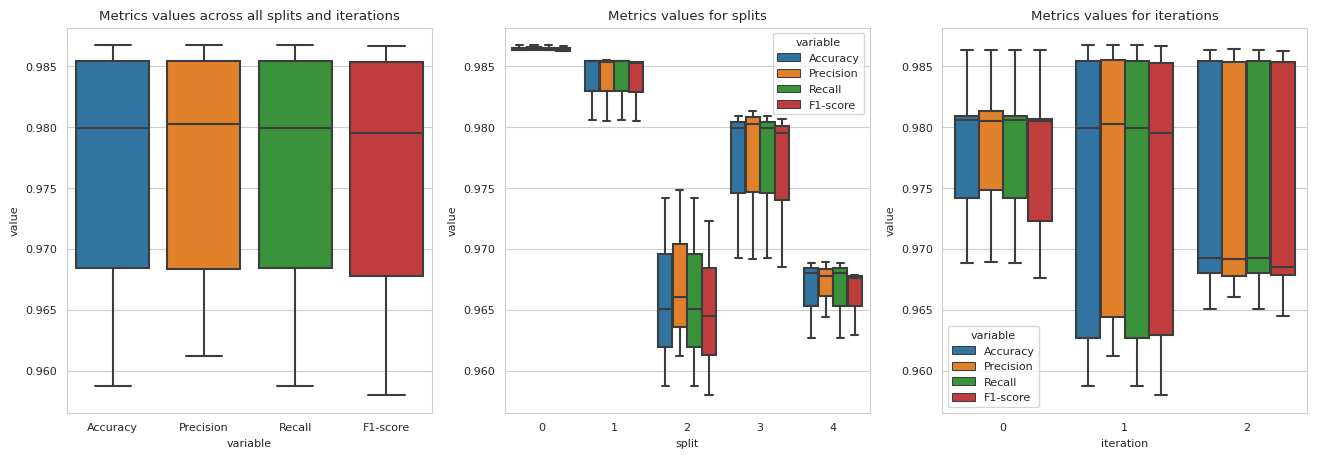

In [104]:
sns.set_style(style='whitegrid')
sns.set_context(rc={"font.size":8})
sns.set_palette(palette='tab10')
fig, ax=plt.subplots(1,3, figsize=(16,5))
sns.boxplot(data=mres, x='variable', y='value',  ax=ax[0])
sns.boxplot(data=mres, x='split', y='value', hue='variable',  ax=ax[1])
sns.boxplot(data=mres, x='iteration', y='value', hue='variable',  ax=ax[2])
ax[0].set_title('Metrics values across all splits and iterations')
ax[1].set_title('Metrics values for splits')
ax[2].set_title('Metrics values for iterations');

In [109]:
hist={k: training_history[k].history for k in training_history.keys()}
hist={k: {v:hist[k][v] for v in hist[k].keys()} for k in hist.keys() }
res_df=pd.DataFrame()
for val in hist.keys():
    _=pd.DataFrame.from_dict(hist[(val[0],val[1])])
    _['split_num']=val[0]
    _['iter']=val[1]
    res_df = pd.concat([_, res_df])
res_df = res_df.reset_index()

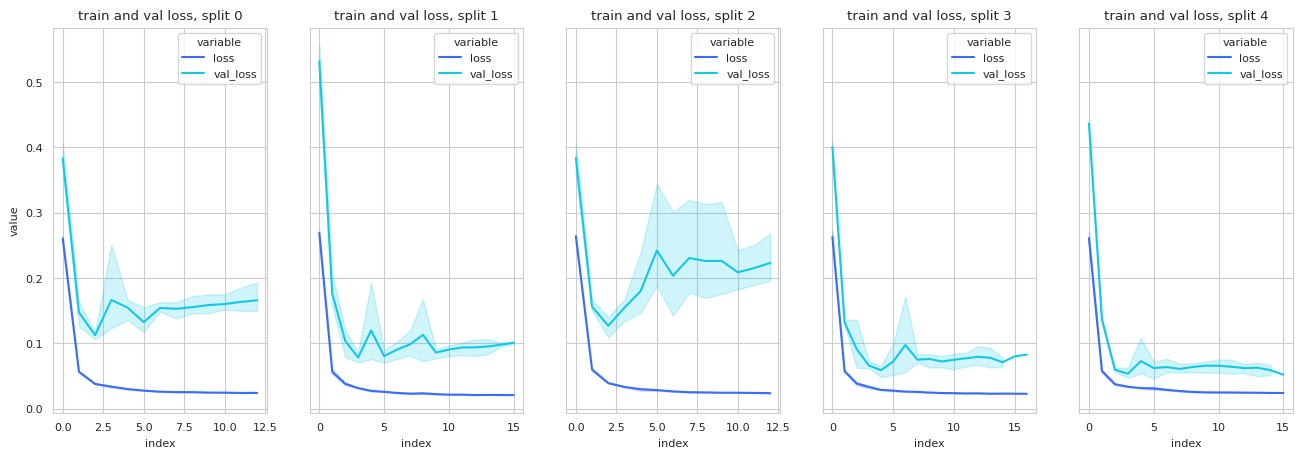

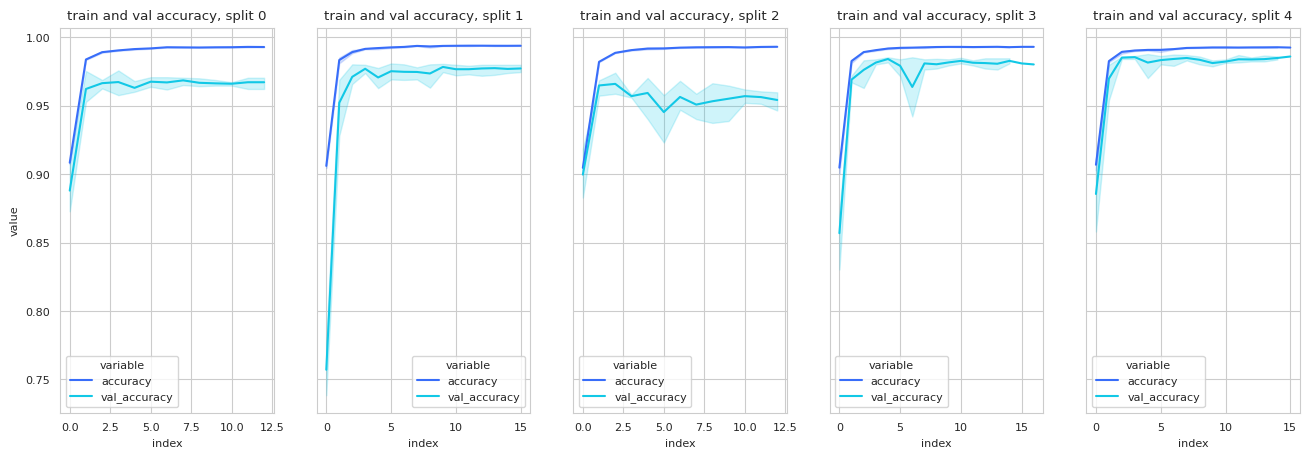

In [134]:
fig, ax=plt.subplots(1,5,figsize=(16,5), sharey=True)
ax=ax.flatten()
for idx, split in enumerate(res_df['split_num'].unique()):
    sns.lineplot(data=pd.melt(res_df.loc[res_df['split_num']==split, ['index','loss', 'val_loss']],id_vars='index'),
                 x='index', y='value', hue='variable', ax=ax[idx], )
    ax[idx].set_title(f'train and val loss, split {idx}')
fig, ax=plt.subplots(1,5,figsize=(16,5), sharey=True)
ax=ax.flatten()
for idx, split in enumerate(res_df['split_num'].unique()):
    sns.lineplot(data=pd.melt(res_df.loc[res_df['split_num']==split, ['index','accuracy', 'val_accuracy']],id_vars='index'),
                 x='index', y='value', hue='variable', ax=ax[idx], )
    ax[idx].set_title(f'train and val accuracy, split {idx}')